<b> Title: </b> Group 11 Proposal - DSCI 100 002 

<b> Group members: </b> Katie Archer, Noor Naila Imtinan Himam, Matthew Yeung, Wenwen Zhao

<b>1. Introduction</b>
<br>
According to scientific research, pulsars are an uncommon form of neutron stars that emit regular pulses of radiation, varying from several seconds to milliseconds in frequency. The potent magnetic fields of these stars generate intense beams of light at both poles. These beams are periodically observed as the pulsar rotates quickly, and they can only be observed with large telescopes when they cross our line of sight from Earth (National Aeronautics and Space Administration, n.d.)

Although pulsars emit a pattern of radio emission that can be detected as they rotate, it can be challenging to distinguish between genuine signals and background noise. Pulsar candidates are being classified as binary classification issues using machine learning tools. The HTRU 2 dataset, which is used to train classification models, includes examples of both real and fake pulsar signals. The class labels used are 0 (negative) and 1 (positive), with the legitimate pulsar examples being the minority positive class. The eight continuous variables are obtained from the integrated pulse profile and the DM-SNR (Disperion Measure - Signal-to-Noise Ratio) curve, which describe the longitude-resolved version of the signal averaged in both time and frequency (Keith et al., 2010). Each candidate in the dataset is described by eight continuous variables, one class variable, and no astronomical information. The integrated pulse profile and the DM-SNR curve are used to determine the eight variables.

In this project, we aim to figure out if information from the integrated pulse profile and DM-SNR curve of pulsar candidates can be used to classify whether signals are legitimate or spurious (real or fake pulsar) with high accuracy.

<b>2. Preliminary exploratory data analysis:</b>


In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
options(repr.matrix.max.rows = 10)

pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", "skew_integrated_profile",
                  "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", "skew_dmsnr", "class"))
pulsar_data <- pulsar_data |> mutate(class = as_factor(class))
pulsar_data 


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0


<b>2a. Create training and testing data split</b>


In [3]:
pulsar_data_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_data_train <- training(pulsar_data_split)
pulsar_data_test <- testing(pulsar_data_split) 

In [15]:
#glimpse(pulsar_data_train)

In [14]:
#glimpse(pulsar_data_test)

<b> Determining our predictors: </b>
    
To determine our preditors, we plot each variable against the class variable (whether the pulsar is real). A class value of "1" corresponds to a real pulsar, whilst a value of "0" corresponds to a false candidate (radio frequency interference or noise).

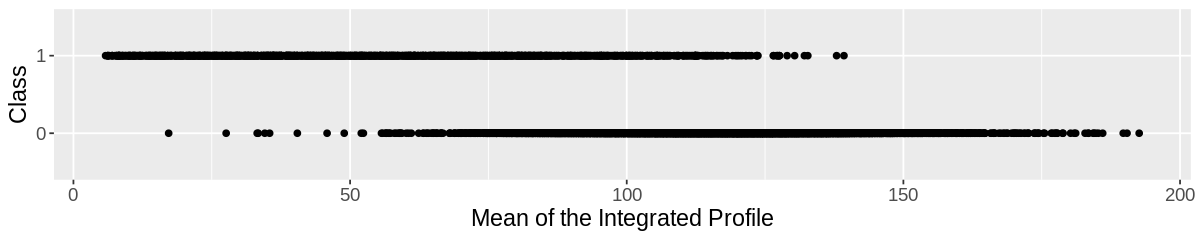

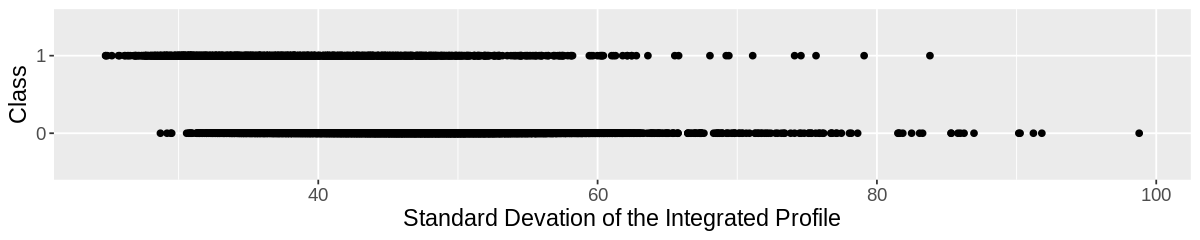

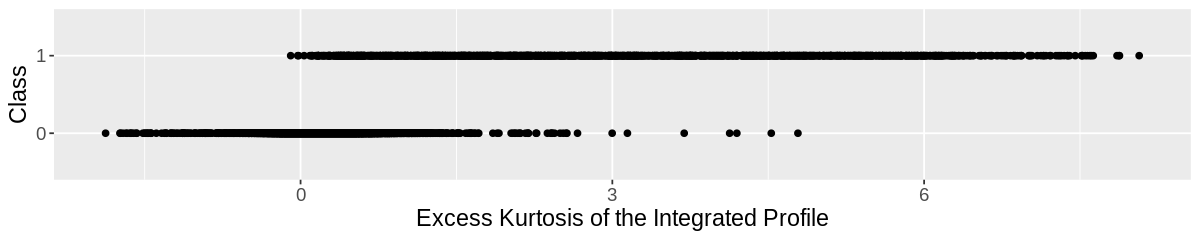

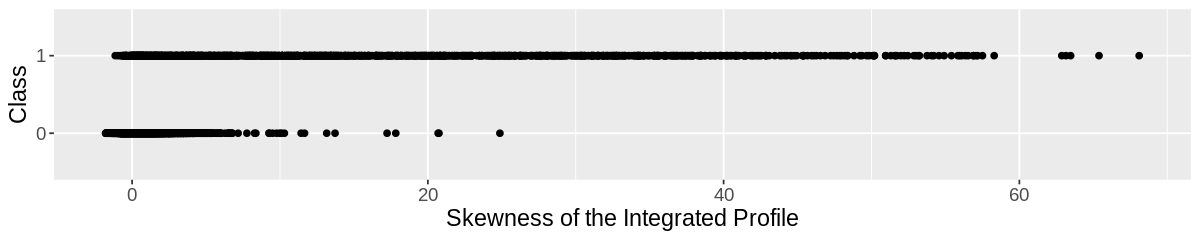

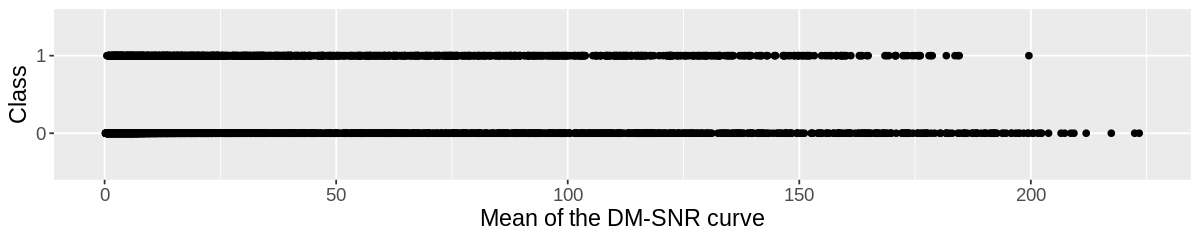

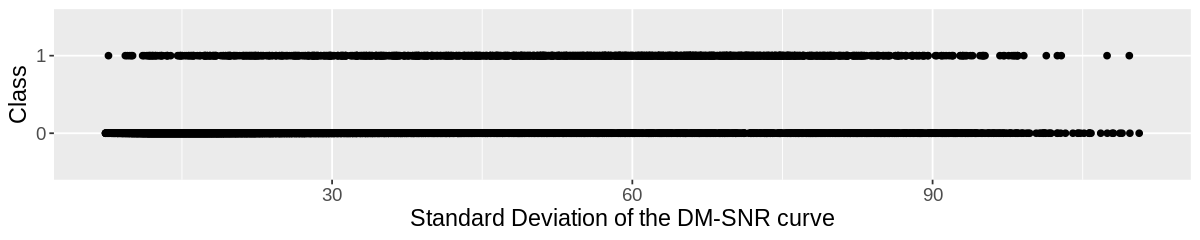

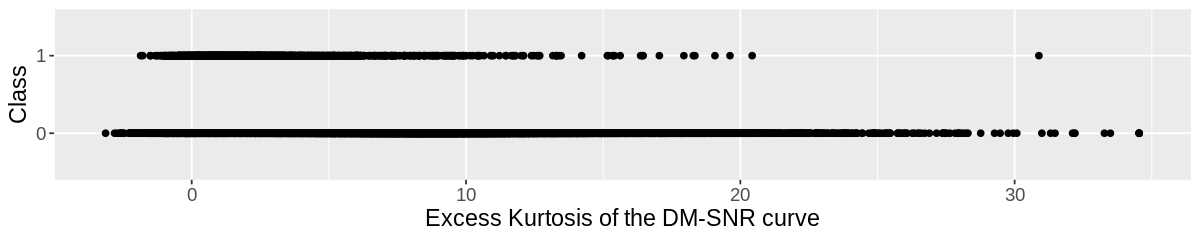

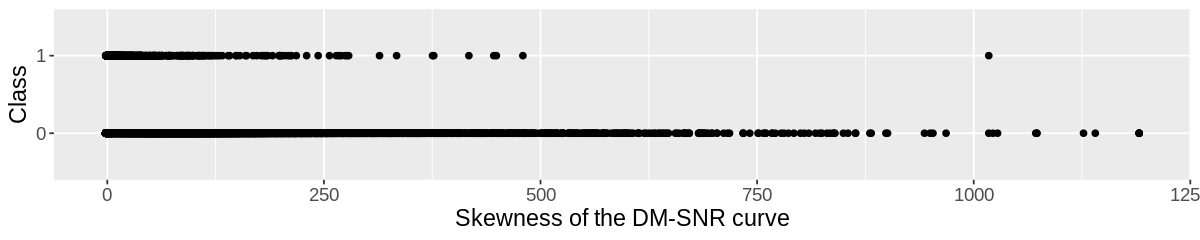

In [6]:
options(repr.plot.width = 10, repr.plot.height = 2)

#variable 1
mean_int_prof_plot <- pulsar_data |>
    ggplot(aes(x = mean_integrated_profile, y = class)) +
    geom_point() +
    labs(x = "Mean of the Integrated Profile", y = "Class") +
    theme(text = element_text(size = 14))
mean_int_prof_plot

#variable 2
stand_dev_int_plot <- pulsar_data |>
    ggplot(aes(x = stand_dev_integrated_profile, y = class)) +
    geom_point() +
    labs(x = "Standard Devation of the Integrated Profile", y = "Class") +
    theme(text = element_text(size = 14))
stand_dev_int_plot

#variable 3
exc_kurt_int_plot <- pulsar_data |>
    ggplot(aes(x = exc_kurtosis_integrated_profile, y = class)) +
    geom_point() +
    labs(x = "Excess Kurtosis of the Integrated Profile", y = "Class") +
    theme(text = element_text(size = 14))
exc_kurt_int_plot

#variable 4
skew_int_plot <- pulsar_data |>
    ggplot(aes(x = skew_integrated_profile, y = class)) +
    geom_point() +
    labs(x = "Skewness of the Integrated Profile", y = "Class") +
    theme(text = element_text(size = 14))
skew_int_plot

#variable 5
mean_dmsnr_plot <- pulsar_data |>
    ggplot(aes(x = mean_dmsnr, y = class)) +
    geom_point() +
    labs(x = "Mean of the DM-SNR curve", y = "Class") +
    theme(text = element_text(size = 14))
mean_dmsnr_plot

#variable 6
dev_dmsnr_plot <- pulsar_data |>
    ggplot(aes(x = stand_dev_dmsnr, y = class)) +
    geom_point() +
    labs(x = "Standard Deviation of the DM-SNR curve", y = "Class") +
    theme(text = element_text(size = 14))
dev_dmsnr_plot

#variable 7
exc_kurt_dmsnr_plot <- pulsar_data |>
    ggplot(aes(x = exc_kurtosis_dmsnr, y = class)) +
    geom_point() +
    labs(x = "Excess Kurtosis of the DM-SNR curve", y = "Class") +
    theme(text = element_text(size = 14))
exc_kurt_dmsnr_plot

#variable 8
skew_dmsnr_plot <- pulsar_data |>
    ggplot(aes(x = skew_dmsnr, y = class)) +
    geom_point() +
    labs(x = "Skewness of the DM-SNR curve", y = "Class") +
    theme(text = element_text(size = 14))
skew_dmsnr_plot

For our predictors, we will choose at least 1 variable for each the integrated profile and the DM-SNR curve, because both are used to distinguish between real pulsar stars and radio frequency interference. Looking at the above plots, we plan on using the skewness of the integrated profile and skewness of the DM-SNR curve as the predictors in our classification model. We are choosing the skewness for both the integrated profile and the DM-SNR curve because there is the least amount of overlap for which values of skewness correspond to both real pulsars and false ones.

<b>2b. Summarize the data in at least one table </b>

In [7]:
class_one <- pulsar_data_train |> 
    filter(class == "1") |>
    nrow()
#class_one

class_zero <- pulsar_data_train |>
    filter(class == "0") |>
    nrow()
#class_zero

mean_predictor_one <- pulsar_data_train |>
    select(skew_integrated_profile) |>
    summarize(mean = mean(skew_integrated_profile)) |>
    pull()
#mean_predictor_one

mean_predictor_two <- pulsar_data_train |>
    select(skew_dmsnr) |>
    summarize(mean = mean(skew_dmsnr)) |>
    pull()
#mean_predictor_two

summary <- tibble(number_of_real_pulsars = class_one, number_of_false_pulsars = class_zero, 
                  mean_of_skewness_int_prof = mean_predictor_one, mean_of_skewness_dmsnr_curve = mean_predictor_two)
summary

number_of_real_pulsars,number_of_false_pulsars,mean_of_skewness_int_prof,mean_of_skewness_dmsnr_curve
<int>,<int>,<dbl>,<dbl>
1254,12169,1.815989,104.8063


This table shows the number of observations in the training set that correspond to each class (real vs. false pulsar), in addition to the mean values of our 2 predictors.

<b>2c. Visualization of Distributions of each of the predictor variables</b>


In [8]:
library(ggplot2) 
library(tidyr)

In [12]:
pulsar_train_var <- select(pulsar_data, skew_integrated_profile,skew_dmsnr)
pulsar_train_dist<- pulsar_train_var|>
                    pivot_longer(colnames(pulsar_train_var)) |>
                    as.data.frame()
#pulsar_train_dist

**Visualization of distributions of each of the predictor variables**

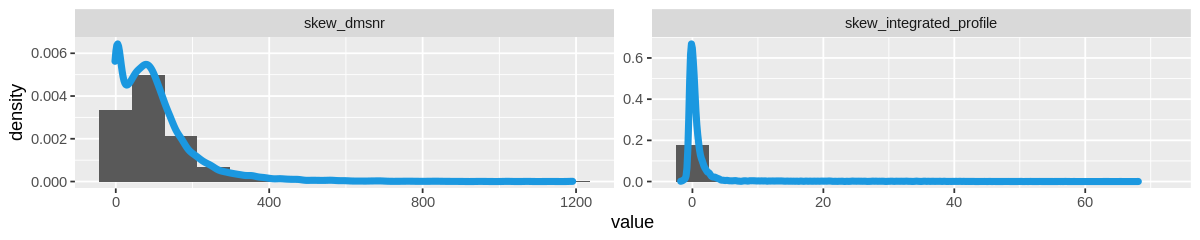

In [13]:
ggp3 <- ggplot(pulsar_train_dist, aes(x = value)) +    # Draw histogram & density
  geom_histogram(aes(y = ..density..),bins=15) + 
  geom_density(col = "#1b98e0", size = 2) + 
  facet_wrap(~ name, scales = "free")
ggp3

<b> Methods: </b>

General steps:
1. Split data set into training and testing sets - 75% of data in training (already done)
2. Standardize the values of the skewness of the integrated profile and the DM-SNR curve to use as the predictors, and predict for class
3. Split training set further, in order to perform 5-fold cross validation to determine best K-value
4. Build a classification model and train the entire training set with the best K-value
5. Predict on the testing set and assess the model's accuracy by collecting metrics and creating visualizations

One way that we will visualize our results is through a scatter plot with the predictor variables on the x- and y- axes and each point representing an observation in the testing set. We will colour code the points by class, in terms of whether or not our model classified them correctly. We will use 4 colours; one to indicate that an observation was predicted correctly as a real pulsar, one to indicate that an observation was predicted correctly as a false pulsar, one to indicate that an observation was predicted incorrectly as a real pulsar when in the testing set it was labelled as fake, and a final one to indicate that an observation was predicted incorrectly as a false pulsar when in fact it was real as labelled in the testing set. This will give a visual of how accurate the model was, and for which values of the standardized predictors the model had the most trouble classifying candidates correctly.


<b> Conclusion: </b>
<br>
We expect to develop a classification model with high accuracy in distinguishing real pulsars from spurious signals in the HTRU2 dataset. By exploring the dataset, we hope to identify the most significant features that contribute to the classification process. The results will be significant as it will provide an efficient and automated method for identifying real pulsars, which otherwise could be missed due to the overwhelming amount of spurious signals.

The findings could have a significant impact on the field of pulsar astronomy, as it would enable more accurate identification and characterization of pulsars. The identification of pulsars provides valuable information about space-time, the inter-stellar medium, and states of matter, which can be used to further scientific research in these areas. Moreover, our study could also have broader implications for the application of machine learning in the field of astronomy. The development of an accurate classification model for pulsar identification could serve as a template for future studies on classifying other types of astronomical objects.

This project could lead to future questions such as: How well does the developed model perform on different datasets of pulsar candidates collected from other surveys? Can the identified pulsars be used for practical applications such as navigation or communication systems?


**References**

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Keith, M. J., et al. (2010). The HTRU survey. Handbook of pulsar astronomy, 379-422.

United States. National Aeronautics and Space Administration. NASA technical note. Washington :National Aeronautics and Space Administration.

